In [2]:
# Import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine Learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Statistical tests for drift detection
from scipy.stats import ks_2samp  # Kolmogorov-Smirnov test

# Make plots look nice
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)  # For reproducible results

print("✅ All libraries loaded successfully!")
print("📖 Ready to learn about drift detection!")

✅ All libraries loaded successfully!
📖 Ready to learn about drift detection!


In [3]:
def create_simple_flight_data(n_flights=1000, scenario='normal'):
    """
    Create simple flight data that's easy to understand
    
    Features:
    - weather: Clear, Rain, Snow
    - hour: Departure hour (6-23)
    - airline: A, B, C (A is most reliable)
    - distance: Flight distance in miles
    """
    np.random.seed(42 if scenario == 'normal' else 123)
    
    # Simple weather conditions
    if scenario == 'weather_drift':
        # More bad weather due to climate change
        weather = np.random.choice(['Clear', 'Rain', 'Snow'], 
                                 size=n_flights, 
                                 p=[0.4, 0.4, 0.2])  # More rain and snow
        print("🌦️ Simulating climate change - more bad weather!")
    else:
        # Normal weather
        weather = np.random.choice(['Clear', 'Rain', 'Snow'], 
                                 size=n_flights, 
                                 p=[0.7, 0.2, 0.1])  # Mostly clear
    
    # Departure hours (6 AM to 11 PM)
    hours = np.random.randint(6, 24, n_flights)
    
    # Airlines (A is best, C is worst)
    airlines = np.random.choice(['Airline_A', 'Airline_B', 'Airline_C'], 
                               size=n_flights, 
                               p=[0.4, 0.4, 0.2])
    
    # Flight distances (200-2000 miles)
    distances = np.random.randint(200, 2000, n_flights)
    
    # Create DataFrame
    df = pd.DataFrame({
        'weather': weather,
        'departure_hour': hours,
        'airline': airlines,
        'distance_miles': distances
    })
    
    # Calculate delay probability based on simple rules
    delay_prob = 0.1  # Base 10% chance of delay
    
    # Weather affects delays
    delay_prob += (df['weather'] == 'Rain') * 0.2    # +20% for rain
    delay_prob += (df['weather'] == 'Snow') * 0.4    # +40% for snow
    
    # Rush hours have more delays
    rush_hours = (df['departure_hour'].isin([7, 8, 17, 18, 19]))
    delay_prob += rush_hours * 0.15  # +15% during rush hours
    
    # Airline quality affects delays
    delay_prob += (df['airline'] == 'Airline_B') * 0.05  # +5% for Airline B
    delay_prob += (df['airline'] == 'Airline_C') * 0.15  # +15% for Airline C
    
    # Longer flights slightly more likely to be delayed
    delay_prob += (df['distance_miles'] > 1000) * 0.05
    
    # Concept drift: Airlines improve (same inputs, different outcomes)
    if scenario == 'concept_drift':
        print("🔄 Simulating airline improvements - better performance!")
        delay_prob *= 0.7  # 30% reduction in delays due to better operations
    
    # Generate actual delays (True/False)
    is_delayed = np.random.random(n_flights) < delay_prob
    df['is_delayed'] = is_delayed
    
    return df

# Create our baseline data (normal conditions)
print("📊 Creating baseline flight data...")
baseline_data = create_simple_flight_data(2000, scenario='normal')

print(f"✅ Created {len(baseline_data)} flight records")
print(f"📈 Baseline delay rate: {baseline_data['is_delayed'].mean():.1%}")
print("\n🔍 First 5 records:")
baseline_data.head()

📊 Creating baseline flight data...
✅ Created 2000 flight records
📈 Baseline delay rate: 29.6%

🔍 First 5 records:


,weather,departure_hour,airline,distance_miles,is_delayed
0,Clear,12,Airline_C,1677,False
1,Snow,8,Airline_A,1085,False
2,Rain,19,Airline_A,1790,False
3,Clear,15,Airline_C,596,False
4,Clear,21,Airline_C,1738,True


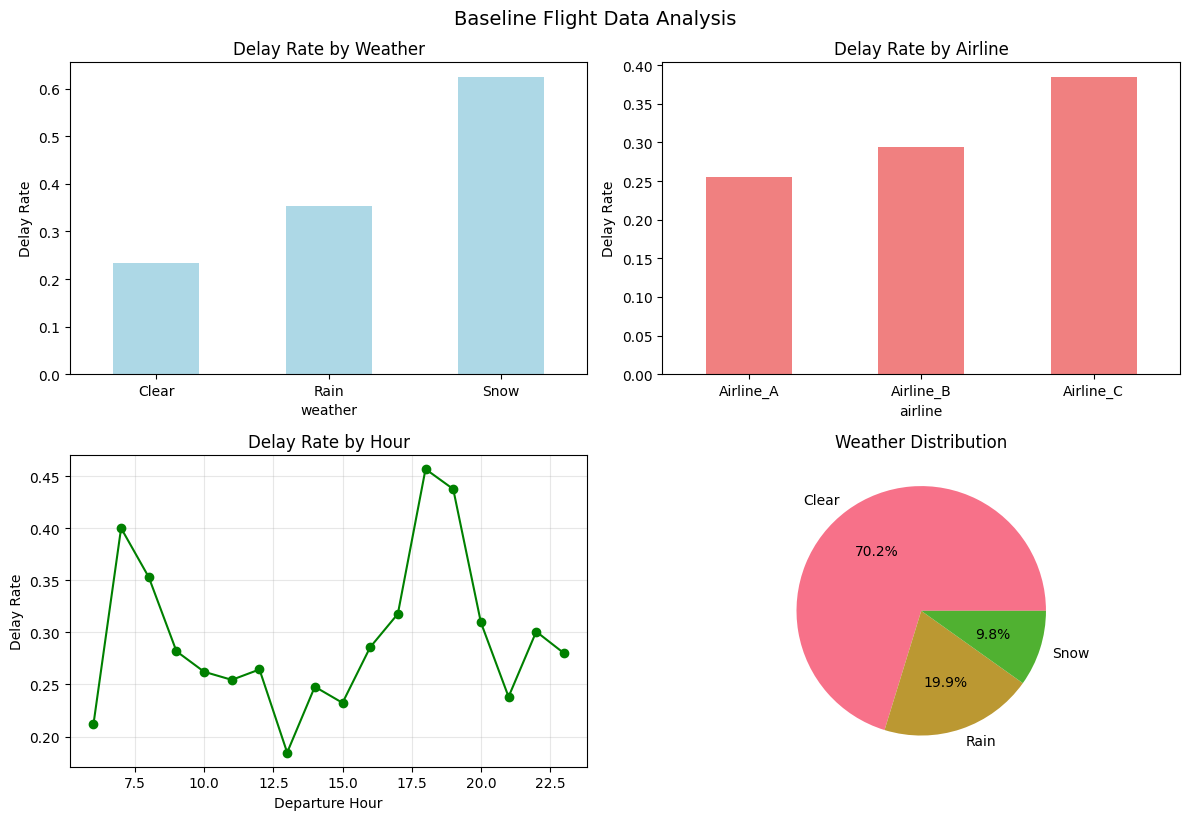

📊 Key Insights:
   • Snow causes the most delays (62.4%)
   • Airline_C has highest delays (38.4%)
   • Rush hours (7-8, 17-19) have more delays
   • Most flights are in clear weather (70.2%)


In [4]:
# Create simple visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Delay rate by weather
weather_delays = baseline_data.groupby('weather')['is_delayed'].mean()
weather_delays.plot(kind='bar', ax=axes[0,0], color='lightblue')
axes[0,0].set_title('Delay Rate by Weather')
axes[0,0].set_ylabel('Delay Rate')
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Delay rate by airline
airline_delays = baseline_data.groupby('airline')['is_delayed'].mean()
airline_delays.plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Delay Rate by Airline')
axes[0,1].set_ylabel('Delay Rate')
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Delay rate by hour
hourly_delays = baseline_data.groupby('departure_hour')['is_delayed'].mean()
axes[1,0].plot(hourly_delays.index, hourly_delays.values, marker='o', color='green')
axes[1,0].set_title('Delay Rate by Hour')
axes[1,0].set_xlabel('Departure Hour')
axes[1,0].set_ylabel('Delay Rate')
axes[1,0].grid(True, alpha=0.3)

# 4. Weather distribution
weather_counts = baseline_data['weather'].value_counts()
axes[1,1].pie(weather_counts.values, labels=weather_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Weather Distribution')

plt.tight_layout()
plt.suptitle('Baseline Flight Data Analysis', fontsize=14, y=1.02)
plt.show()

print("📊 Key Insights:")
print(f"   • Snow causes the most delays ({weather_delays['Snow']:.1%})")
print(f"   • Airline_C has highest delays ({airline_delays['Airline_C']:.1%})")
print(f"   • Rush hours (7-8, 17-19) have more delays")
print(f"   • Most flights are in clear weather ({weather_counts['Clear']/len(baseline_data):.1%})")

In [5]:
def prepare_data_for_model(df):
    """
    Convert text data to numbers so the ML model can use it
    """
    df_processed = df.copy()
    
    # Convert weather to numbers: Clear=0, Rain=1, Snow=2
    weather_encoder = LabelEncoder()
    df_processed['weather_encoded'] = weather_encoder.fit_transform(df_processed['weather'])
    
    # Convert airline to numbers: Airline_A=0, Airline_B=1, Airline_C=2
    airline_encoder = LabelEncoder()
    df_processed['airline_encoded'] = airline_encoder.fit_transform(df_processed['airline'])
    
    # Add rush hour indicator (0 or 1)
    df_processed['is_rush_hour'] = df_processed['departure_hour'].isin([7, 8, 17, 18, 19]).astype(int)
    
    return df_processed, weather_encoder, airline_encoder

# Prepare the data
print("🔧 Preparing data for machine learning...")
baseline_processed, weather_encoder, airline_encoder = prepare_data_for_model(baseline_data)

# Select features (inputs) and target (output)
features = ['weather_encoded', 'departure_hour', 'airline_encoded', 'distance_miles', 'is_rush_hour']
X = baseline_processed[features]
y = baseline_processed['is_delayed']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest model (easy to understand)
print("🤖 Training machine learning model...")
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Test the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Model trained successfully!")
print(f"📊 Model accuracy: {accuracy:.1%}")

# Show feature importance (what the model finds most important)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Most important features for predicting delays:")
for _, row in feature_importance.iterrows():
    print(f"   • {row['feature']}: {row['importance']:.3f}")

🔧 Preparing data for machine learning...
🤖 Training machine learning model...
✅ Model trained successfully!
📊 Model accuracy: 66.0%

🔍 Most important features for predicting delays:
   • distance_miles: 0.665
   • departure_hour: 0.182
   • weather_encoded: 0.075
   • airline_encoded: 0.053
   • is_rush_hour: 0.025


🌦️ Simulating DATA DRIFT: Climate change causing more bad weather...
🌦️ Simulating climate change - more bad weather!
📊 New delay rate: 39.3%
📈 Change from baseline: +9.7%


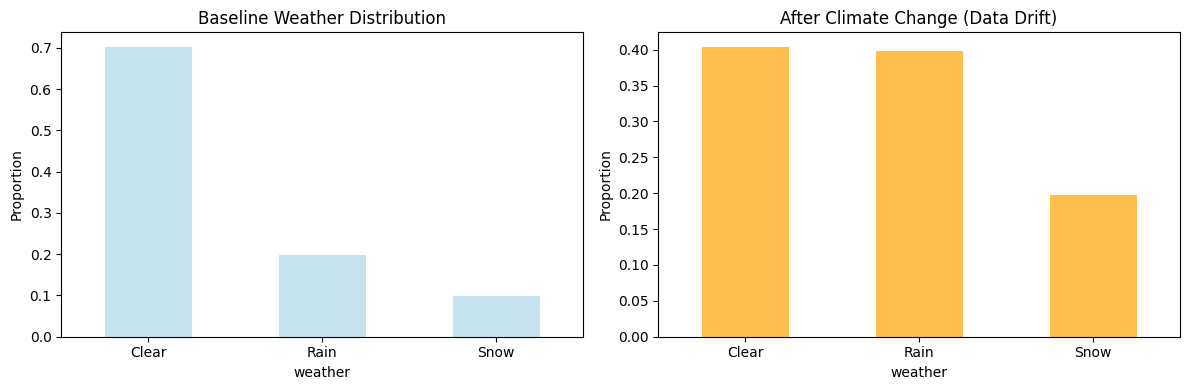


🔍 Weather Distribution Changes:
   • Clear: 70.2% → 40.4% (-29.8%)
   • Rain: 19.9% → 39.8% (+19.9%)
   • Snow: 9.8% → 19.8% (+10.0%)


In [6]:
# Create new data with weather drift (climate change)
print("🌦️ Simulating DATA DRIFT: Climate change causing more bad weather...")
weather_drift_data = create_simple_flight_data(1000, scenario='weather_drift')

print(f"📊 New delay rate: {weather_drift_data['is_delayed'].mean():.1%}")
print(f"📈 Change from baseline: {weather_drift_data['is_delayed'].mean() - baseline_data['is_delayed'].mean():+.1%}")

# Compare weather distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Baseline weather
baseline_weather = baseline_data['weather'].value_counts(normalize=True)
baseline_weather.plot(kind='bar', ax=ax1, color='lightblue', alpha=0.7)
ax1.set_title('Baseline Weather Distribution')
ax1.set_ylabel('Proportion')
ax1.tick_params(axis='x', rotation=0)

# Weather drift
drift_weather = weather_drift_data['weather'].value_counts(normalize=True)
drift_weather.plot(kind='bar', ax=ax2, color='orange', alpha=0.7)
ax2.set_title('After Climate Change (Data Drift)')
ax2.set_ylabel('Proportion')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\n🔍 Weather Distribution Changes:")
for weather in ['Clear', 'Rain', 'Snow']:
    baseline_pct = baseline_weather.get(weather, 0) * 100
    drift_pct = drift_weather.get(weather, 0) * 100
    change = drift_pct - baseline_pct
    print(f"   • {weather}: {baseline_pct:.1f}% → {drift_pct:.1f}% ({change:+.1f}%)")

In [7]:
def detect_data_drift(baseline_data, new_data, feature, threshold=0.05):
    """
    Use statistical test to detect if data has changed significantly
    
    Uses Kolmogorov-Smirnov test for numerical features
    Returns True if drift detected
    """
    if feature in baseline_data.columns and feature in new_data.columns:
        baseline_values = baseline_data[feature]
        new_values = new_data[feature]
        
        # Statistical test
        statistic, p_value = ks_2samp(baseline_values, new_values)
        
        # If p_value < threshold, we reject the hypothesis that distributions are the same
        drift_detected = p_value < threshold
        
        return {
            'feature': feature,
            'drift_detected': drift_detected,
            'p_value': p_value,
            'test_statistic': statistic
        }
    return None

# Test for drift in numerical features
print("🔍 Testing for Data Drift...")
print("=" * 40)

numerical_features = ['departure_hour', 'distance_miles']

for feature in numerical_features:
    result = detect_data_drift(baseline_data, weather_drift_data, feature)
    if result:
        status = "🚨 DRIFT DETECTED" if result['drift_detected'] else "✅ NO DRIFT"
        print(f"{feature:15} | {status} | p-value: {result['p_value']:.4f}")

# For categorical features (weather, airline), compare distributions manually
print("\n🔍 Testing Weather Distribution Change...")
baseline_weather_dist = baseline_data['weather'].value_counts(normalize=True)
drift_weather_dist = weather_drift_data['weather'].value_counts(normalize=True)

# Calculate total variation distance (simple measure of distribution difference)
weather_categories = set(baseline_weather_dist.index) | set(drift_weather_dist.index)
total_variation = 0
for category in weather_categories:
    baseline_prop = baseline_weather_dist.get(category, 0)
    drift_prop = drift_weather_dist.get(category, 0)
    total_variation += abs(baseline_prop - drift_prop)

total_variation = total_variation / 2  # Normalize

weather_drift_detected = total_variation > 0.1  # 10% threshold
status = "🚨 DRIFT DETECTED" if weather_drift_detected else "✅ NO DRIFT"
print(f"weather          | {status} | Total Variation: {total_variation:.3f}")

if weather_drift_detected:
    print("\n⚠️  ALERT: Weather distribution has changed significantly!")
    print("💡 This could affect model performance. Consider retraining.")

🔍 Testing for Data Drift...
departure_hour  | ✅ NO DRIFT | p-value: 0.9814
distance_miles  | ✅ NO DRIFT | p-value: 0.4027

🔍 Testing Weather Distribution Change...
weather          | 🚨 DRIFT DETECTED | Total Variation: 0.298

⚠️  ALERT: Weather distribution has changed significantly!
💡 This could affect model performance. Consider retraining.


🔄 Simulating CONCEPT DRIFT: Airlines improve operations...
🔄 Simulating airline improvements - better performance!
📊 New delay rate: 22.1%
📈 Change from baseline: -7.5%

🔍 Same Weather, Different Outcomes (Concept Drift):


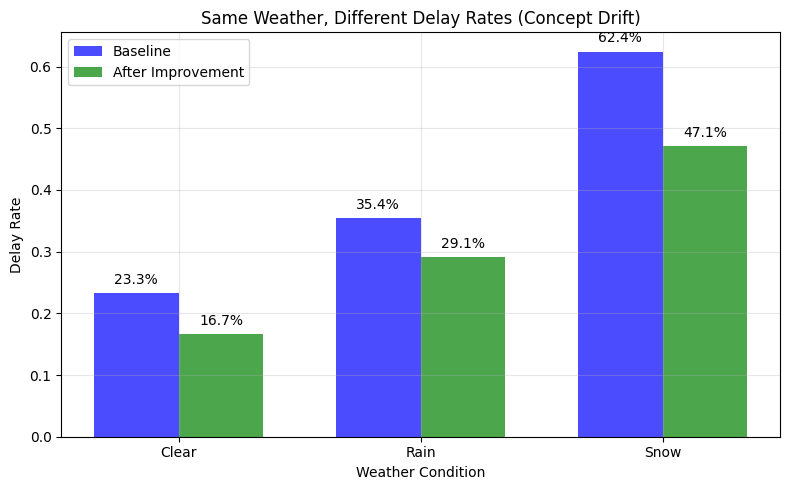


📊 Delay Rate Changes by Weather:
   • Clear: 23.3% → 16.7% (-6.7%)
   • Rain: 35.4% → 29.1% (-6.3%)
   • Snow: 62.4% → 47.1% (-15.3%)


In [8]:
# Create new data with concept drift (airlines improve)
print("🔄 Simulating CONCEPT DRIFT: Airlines improve operations...")
concept_drift_data = create_simple_flight_data(1000, scenario='concept_drift')

print(f"📊 New delay rate: {concept_drift_data['is_delayed'].mean():.1%}")
print(f"📈 Change from baseline: {concept_drift_data['is_delayed'].mean() - baseline_data['is_delayed'].mean():+.1%}")

# Compare the same weather conditions but different delay rates
print("\n🔍 Same Weather, Different Outcomes (Concept Drift):")

baseline_weather_delays = baseline_data.groupby('weather')['is_delayed'].mean()
concept_weather_delays = concept_drift_data.groupby('weather')['is_delayed'].mean()

fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(baseline_weather_delays))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_weather_delays.values, width, label='Baseline', alpha=0.7, color='blue')
bars2 = ax.bar(x + width/2, concept_weather_delays.values, width, label='After Improvement', alpha=0.7, color='green')

ax.set_xlabel('Weather Condition')
ax.set_ylabel('Delay Rate')
ax.set_title('Same Weather, Different Delay Rates (Concept Drift)')
ax.set_xticks(x)
ax.set_xticklabels(baseline_weather_delays.index)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n📊 Delay Rate Changes by Weather:")
for weather in baseline_weather_delays.index:
    baseline_rate = baseline_weather_delays[weather]
    concept_rate = concept_weather_delays[weather]
    change = concept_rate - baseline_rate
    print(f"   • {weather}: {baseline_rate:.1%} → {concept_rate:.1%} ({change:+.1%})")

🤖 Testing Model Performance on New Data...
📊 Baseline Accuracy (test set):     66.0%
🌦️ Weather Drift Accuracy:           58.8% (+7.2%)
🔄 Concept Drift Accuracy:           69.0% (-3.0%)

🔍 Drift Detection Results:
⚠️  Weather drift detected: 7.2% performance drop
✅ Concept drift manageable: -3.0% performance drop


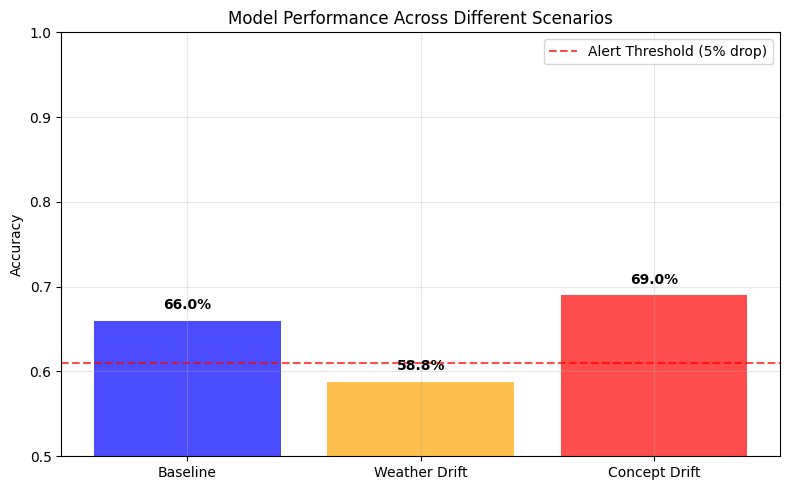

In [9]:
def test_model_performance(model, new_data, weather_encoder, airline_encoder):
    """
    Test how well our model performs on new data
    """
    # Prepare the new data the same way as training data
    new_processed = new_data.copy()
    
    # Convert text to numbers using the same encoders
    new_processed['weather_encoded'] = weather_encoder.transform(new_processed['weather'])
    new_processed['airline_encoded'] = airline_encoder.transform(new_processed['airline'])
    new_processed['is_rush_hour'] = new_processed['departure_hour'].isin([7, 8, 17, 18, 19]).astype(int)
    
    # Make predictions
    X_new = new_processed[features]
    y_new = new_processed['is_delayed']
    y_pred_new = model.predict(X_new)
    
    # Calculate accuracy
    new_accuracy = accuracy_score(y_new, y_pred_new)
    
    return new_accuracy

# Test model on different scenarios
print("🤖 Testing Model Performance on New Data...")
print("=" * 50)

# Baseline performance (from training)
baseline_accuracy = accuracy
print(f"📊 Baseline Accuracy (test set):     {baseline_accuracy:.1%}")

# Weather drift performance
weather_drift_accuracy = test_model_performance(model, weather_drift_data, weather_encoder, airline_encoder)
weather_performance_drop = baseline_accuracy - weather_drift_accuracy
print(f"🌦️ Weather Drift Accuracy:           {weather_drift_accuracy:.1%} ({weather_performance_drop:+.1%})")

# Concept drift performance
concept_drift_accuracy = test_model_performance(model, concept_drift_data, weather_encoder, airline_encoder)
concept_performance_drop = baseline_accuracy - concept_drift_accuracy
print(f"🔄 Concept Drift Accuracy:           {concept_drift_accuracy:.1%} ({concept_performance_drop:+.1%})")

# Detect significant performance drops
print("\n🔍 Drift Detection Results:")
threshold = 0.05  # 5% performance drop threshold

if weather_performance_drop > threshold:
    print(f"⚠️  Weather drift detected: {weather_performance_drop:.1%} performance drop")
else:
    print(f"✅ Weather drift manageable: {weather_performance_drop:.1%} performance drop")

if concept_performance_drop > threshold:
    print(f"🚨 Concept drift detected: {concept_performance_drop:.1%} performance drop")
    print("💡 Recommendation: Retrain model with new data")
else:
    print(f"✅ Concept drift manageable: {concept_performance_drop:.1%} performance drop")

# Visualize performance comparison
scenarios = ['Baseline', 'Weather Drift', 'Concept Drift']
accuracies = [baseline_accuracy, weather_drift_accuracy, concept_drift_accuracy]
colors = ['blue', 'orange', 'red']

plt.figure(figsize=(8, 5))
bars = plt.bar(scenarios, accuracies, color=colors, alpha=0.7)
plt.title('Model Performance Across Different Scenarios')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)

# Add value labels
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

# Add threshold line
plt.axhline(y=baseline_accuracy - threshold, color='red', linestyle='--', alpha=0.7, 
            label=f'Alert Threshold ({threshold:.0%} drop)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()